In [163]:
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
import seaborn as sns

import os

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [164]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [165]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import data

Data source: https://www.kaggle.com/datasets/team-ai/spam-text-message-classification

In [166]:
data = pd.read_csv('/content/drive/MyDrive/SPAM text message 20170820 - Data.csv')
data

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [167]:
# import glove
embedding_index = {}
with open('/content/drive/MyDrive/glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Exploratory Data Analysis (EDA)

### General description

Conclusion:
- There are 5572 rows in the dataset;
- There are 2 columns in the dataset, "Category" and "Message";
- There are 2 types of categories;
- There are repeated messages;
- The top category, that is, the most repeated one, is 'ham'


In [168]:
print(len(data))
data.describe()

5572


,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


### Number of null elements

Conclusion: It is possible to check that there is no null values in the dataset.

In [169]:
data.isnull().sum()

,0
Category,0
Message,0


### Classes analysis
Types of categories and number of rows for each type

Conclusion:
- There are 2 different classes: 'ham' and 'spam';
- There are 4825 messages in the 'ham' class and 747 messages in the 'spam' class.

In [170]:
print(data['Category'].unique())

['ham' 'spam']


Category
ham     4825
spam     747
Name: count, dtype: int64


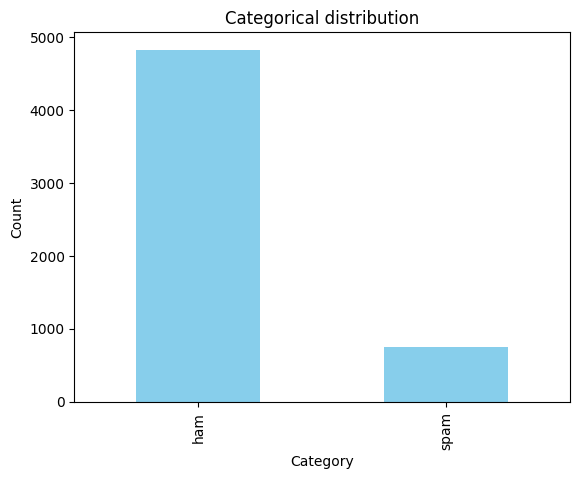

In [171]:
category_counts = data['Category'].value_counts()

category_counts.plot(kind='bar', color='skyblue')

plt.title('Categorical distribution')
plt.xlabel('Category')
plt.ylabel('Count')

print(category_counts)
plt.show()

### Messages analysis

Conclusion:
- The shortest message has 2 characters, and the longest one has 910 characters;
- Both shortest and longest messages were printed bellow.

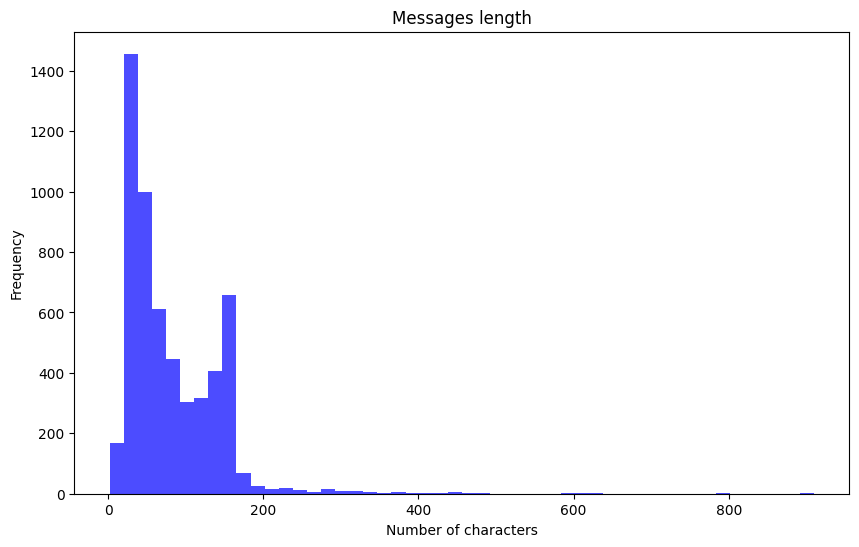

In [172]:
data['message_length'] = data['Message'].apply(len)

plt.figure(figsize=(10,6))
data['message_length'].plot(kind='hist', bins=50, alpha=0.7, color='blue')
plt.title('Messages length')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.show()

In [173]:
min_length = data['message_length'].min()
max_length = data['message_length'].max()

print('Shortest message length: ', str(min_length))
print('Longest message length: ', str(max_length))

shortest_message = data.loc[data['message_length'] == min_length, 'Message'].values[0]
longest_message = data.loc[data['message_length'] == max_length, 'Message'].values[0]

print('Shortest message: ', shortest_message)
print('Longest message: ', longest_message)

Shortest message length:  2
Longest message length:  910
Shortest message:  Ok
Longest message:  For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell 

# Apply preprocessing

The pipeline consists of:
1. **Tokenization**: Breaking down the text into individual words (tokens) to achieve a better and faster processing of the text.
2. **Lemmatization**: Reducing words to their base form (e.g., "running" becomes "run"), which helps in standardizing the text and improving model performance. Before lemmatization, the words in the message filtered through two steps:
  - **Stopwords**: Eliminate common words such as "and", "is", "the", etc., that do not carry much meaning in the message.
  - **Punctuation**: Exclude punctuation marks (such as periods, commas, question marks, etc.) to ensure that the text is free of unnecessary symbols, which they could interfere in the text processing.

By the end of the pipeline, the dataframe will have a new column 'processed_message' that consists of the return of the method 'preprocess_pipeline' applied to the row message.

In [174]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [175]:
def preprocess_pipeline(message):
    tokens = word_tokenize(message.lower())
    processed_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token.isalpha()]

    return processed_tokens

In [176]:
data['processed_message'] = data['Message'].apply(preprocess_pipeline)

In [177]:
data.head(10)

,Category,Message,message_length,processed_message
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,29,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,49,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[nah, think, go, usf, life, around, though]"
5,spam,FreeMsg Hey there darling it's been 3 week's n...,147,"[freemsg, hey, darling, week, word, back, like..."
6,ham,Even my brother is not like to speak with me. ...,77,"[even, brother, like, speak, treat, like, aid,..."
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160,"[per, request, melle, oru, minnaminunginte, nu..."
8,spam,WINNER!! As a valued network customer you have...,157,"[winner, valued, network, customer, selected, ..."
9,spam,Had your mobile 11 months or more? U R entitle...,154,"[mobile, month, u, r, entitled, update, latest..."


In [178]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['Category'])

data['binary_category'] = y_encoded

data['binary_category'].head(6)

,binary_category
0,0
1,0
2,1
3,0
4,0
5,1


In [179]:
X = data['processed_message'].apply(lambda x: ' '.join(x))
y = data['binary_category']

# LSTM & Glove vectorization

In [180]:
MAX_NUM_WORDS = 10000  # Maximun size of the vocabulary
MAX_SEQUENCE_LENGTH = 100  # Maximun size of a sequence
EMBEDDING_DIM = 50  # Embeddings dimension

## Glove

In [181]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)

X_padded = pad_sequences(X_seq, maxlen=MAX_SEQUENCE_LENGTH)

X_train, X_test, y_train, y_test_LSTM = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Create embeddings matrix based on glove
word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## LSTM

In [182]:
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test_LSTM))

# Avaliar o modelo
y_pred_LSTM = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test_LSTM, y_pred_LSTM, target_names=label_encoder.classes_))


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 222ms/step - accuracy: 0.8886 - loss: 0.3476 - val_accuracy: 0.9605 - val_loss: 0.1260
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step - accuracy: 0.9580 - loss: 0.1197 - val_accuracy: 0.9641 - val_loss: 0.1095
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.9729 - loss: 0.0874 - val_accuracy: 0.9596 - val_loss: 0.1084
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 216ms/step - accuracy: 0.9755 - loss: 0.0795 - val_accuracy: 0.9686 - val_loss: 0.0969
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 219ms/step - accuracy: 0.9767 - loss: 0.0702 - val_accuracy: 0.9659 - val_loss: 0.1079
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       966
        spam       0.91      0.83      0.87       149

    accuracy                           0.97      1115
   macro avg       0.94      0.91      0.92      1115
weighted avg       0.97      0.97      0.97      1115



# RNN & BoW

In [183]:
# Transform processed_message string into a numeric vector
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(X)

# divide data
X_train, X_test, y_train, y_test_RNN = train_test_split(X_bow, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
history = model.fit(X_train.toarray(), y_train, epochs=5, batch_size=64, validation_data=(X_test.toarray(), y_test_RNN))

# evaluate model
y_pred_RNN = (model.predict(X_test.toarray()) > 0.5).astype("int32")
print(classification_report(y_test_RNN, y_pred_RNN, target_names=label_encoder.classes_))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8770 - loss: 0.4493 - val_accuracy: 0.9749 - val_loss: 0.1036
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9853 - loss: 0.0536 - val_accuracy: 0.9821 - val_loss: 0.0578
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9950 - loss: 0.0148 - val_accuracy: 0.9839 - val_loss: 0.0583
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9985 - loss: 0.0074 - val_accuracy: 0.9830 - val_loss: 0.0632
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9997 - loss: 0.0026 - val_accuracy: 0.9857 - val_loss: 0.0672
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       1.00      0.89      0.94       149

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115



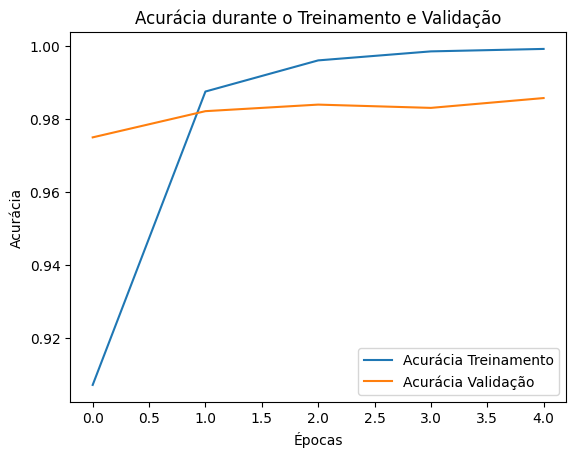

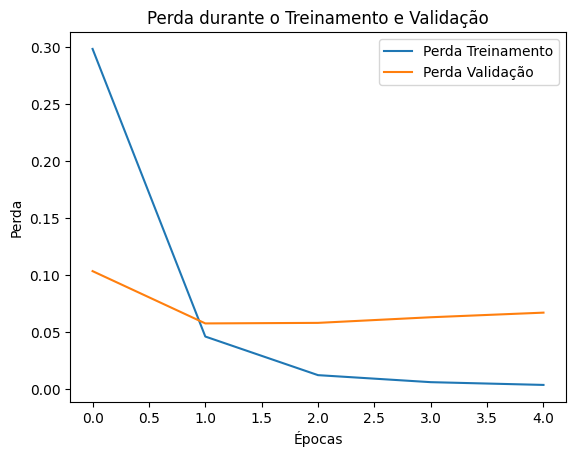

In [184]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Acurácia Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.title('Acurácia durante o Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Perda Treinamento')
plt.plot(history.history['val_loss'], label='Perda Validação')
plt.title('Perda durante o Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

# Compare results

**Accuracy**

The basic RNN model with BoW vectorizer achieved 99% accuracy. Meanwhile, the LSTM model with Glove vectorizer achieved 97% accuracy. In conclusion, both models showed a satisfactory results.

## Visualize confusion matrix

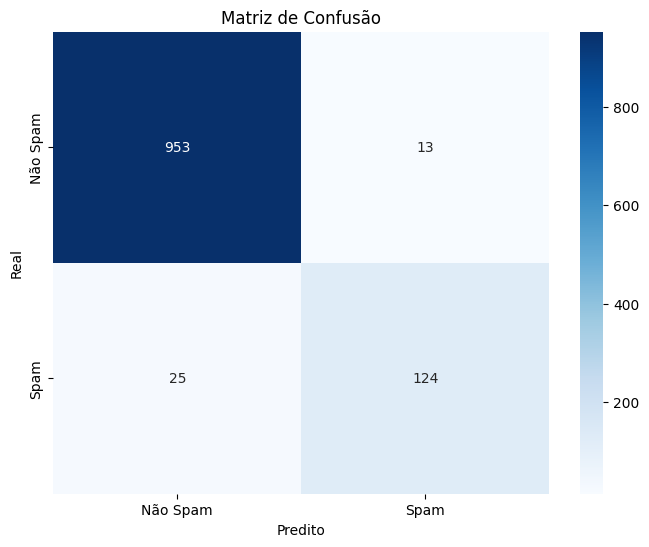

In [185]:
# LSTM model
cm = confusion_matrix(y_test_LSTM, y_pred_LSTM)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Spam', 'Spam'], yticklabels=['Não Spam', 'Spam'])
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

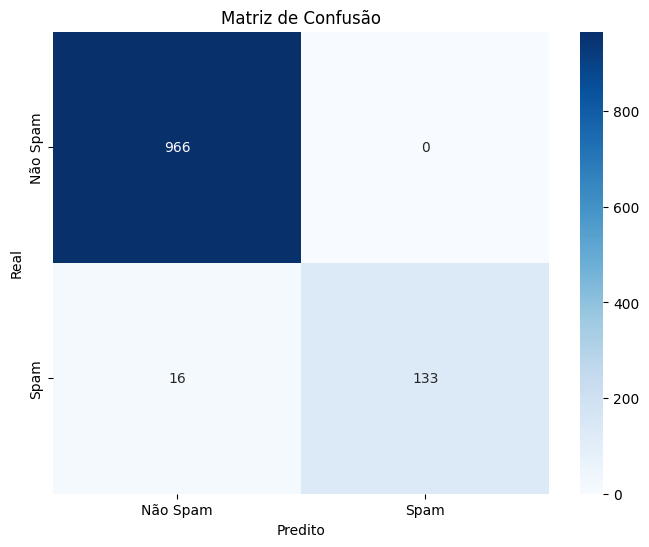

In [186]:
# RNN model
cm = confusion_matrix(y_test_RNN, y_pred_RNN)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Spam', 'Spam'], yticklabels=['Não Spam', 'Spam'])
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In conclusion, both matrices show that the majority of the predictions were correct, but the RNN model was slightly better.